# Autoencoders

## Seoul AI Meetup, July 8

Martin Kersner, <m.kersner@gmail.com>

Structure of this presentation is largely based on chapter *15: Autoencoders* from book [Hands-On Machine Learning with Scikit-Learn & Tensorflow](http://shop.oreilly.com/product/0636920052289.do). Some examples are modified version of https://github.com/ageron/handson-ml.

In [39]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Content
1. Efficient Data Representation
1. Principal Component Analysis (PCA)
1. t-SNE
1. Stacked Autoencoders
1. Unsupervised Pretraining Using Stacked Autoencoders
1. Denoising Autoencoders
1. Sparse Autoencoders
1. Variational Autoencoders
1. Other Autoencoders

## Efficient Data Representation

* Number sequences
    * 56, 46, 8, 56, 7, 6, 8, 52,... 
    * 5, 16, 8, 4, 2, 1, 4, 2, 1,...

* Lower Data Dimensionality
  * Reduced computational cost
  * Easier to train ([Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality))
  * Easier to visualize (ND -> 3D or ND -> 2D)
* [Factor Analysis](https://en.wikipedia.org/wiki/Factor_analysis), [Independent Component Analysis](https://en.wikipedia.org/wiki/Independent_component_analysis)

## Principal Component Analysis

* For unlabeled data
* Transformation from original coordinate system to the new one
* Orthogonal linear transformation
* Used for dimensionality reduction
* Principal components represent directions along which the data has the largest variations
* [sklearn.decomposition.PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

### Yale Face Database
http://vision.ucsd.edu/content/yale-face-database

* 15 people
* 11 images per subject one per different facial expression or configuration
* (center-light w/glasses, happy, left-light, w/no glasses, normal, right-light, sad, sleepy, surprised, and wink)

<img src="https://raw.githubusercontent.com/martinkersner/autoencoder-meetup/master/files/yale-faces.png" />

### PCA applied on Yale Face Database
https://github.com/martinkersner/seoul-artificial-intelligence-meetup/blob/master/eigen-fisher-faces/eigen-faces.ipynb

<img src="https://raw.githubusercontent.com/martinkersner/autoencoder-meetup/master/files/yale-pca.png" />

In [1]:
# scikit-learn: Principal Component Analysis
import numpy as np
from sklearn.decomposition import PCA

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)

print(pca.explained_variance_ratio_)

[ 0.99244289  0.00755711]


## Autoencoders

* Artificial Neural Networks
* Same architecture as Multi-Layer Perceptron
* Number of input neurons = Number of output neuronw
* Trained to efficiently encode (**codings**) input information


* Purposes
  * Decrease dimensionality
  * Feature detectors (unsupervised pretraining for deep neural networks)
  * Randomly generate new data

* Encoder (Recognition network)
* Decoder (Generative network)
 
 <img src="https://inspirehep.net/record/1252540/files/autoencoder.png" />
 Example of **undercomplete** autoencoder.

## Autoencoder as PCA

* Linear activations
* Cost function Mean Squared Error

In [52]:
# source: https://github.com/ageron/handson-ml
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def plot_codings(codings):
    fig = plt.figure(figsize=(4,3))
    plt.plot(codings[:,0], codings[:, 1], "b.")
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.show()
    
def plot_two_codings(codings1, codings2):
    plt.rcParams['axes.labelsize'] = 28
    plt.figure(1, figsize=(12, 6))
    
    plt.subplot(121)
    plt.plot(codings1[:,0], codings1[:, 1], "b.")
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.se
    
    plt.subplot(122)
    plt.plot(codings2[:,0], codings2[:, 1], "b.")
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18, rotation=0)
    
    plt.show()

In [21]:
# PCA
pca = PCA(n_components=2)
pca.fit(X_train)
pca_codings = pca.transform(X_test)

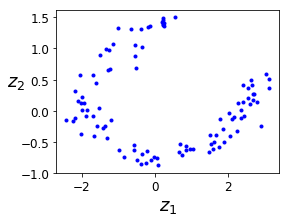

In [29]:
# Encodings created using PCA
plot_codings(pca_codings)

In [25]:
# source: https://github.com/ageron/handson-ml
import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

n_iterations = 50000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

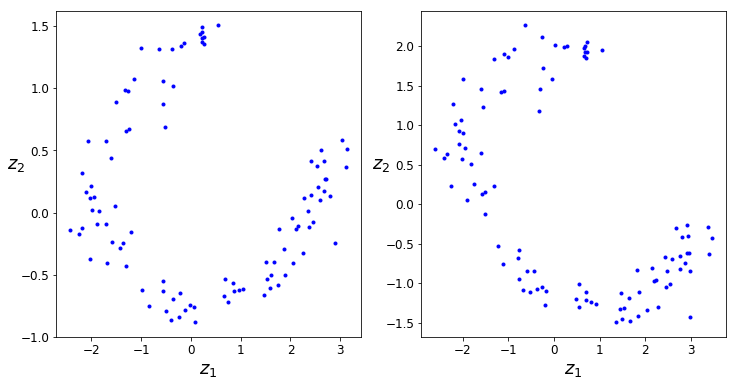

In [53]:
plot_two_codings(pca_codings, codings_val)

## Variational Autoencoders